# Get Elevation Data

In [6]:
import pandas as pd 
import numpy as np
import os 
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px

pd.set_option('display.max_columns', None)

In [2]:
# local or gdrive
path_source = 'gdrive'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'

Mounted at /content/gdrive


In [3]:
# load full dataset
df_all = pd.read_parquet(os.path.join(data_path, 'joined_filtered_data.parquet'))

In [4]:
# function to get elevation at a given lat/lng. Returns -9999 if the elevation is not found. 
def get_elevation(lat, lon):

  url = r'https://nationalmap.gov/epqs/pqs.php?'

  params = {
    'output': 'json',
    'x': lon,
    'y': lat,
    'units': 'Meters'
  }

  # there seems to be an issue with some lat lon, so add error handling
  try:
    result = requests.get((url + urllib.parse.urlencode(params)))
    elevation = result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']
  except:
    elevation = -9999
    
  return elevation

# Get Elevation at Each School

In [ ]:
df_schools = df_all[['cdscode', 'school_lat', 'school_lon']].drop_duplicates()
df_schools.head(3)

,cdscode,school_lat,school_lon
0,20102070109728,37.115210,-120.26603
1,20102072030187,37.115210,-120.26603
2,20651930000000,37.122449,-120.26487


Test it out on 100 records. The elevation is in meters.

In [ ]:
df_test = df_schools.head(100)
df_test['elevation_meters'] = df_test.progress_apply(lambda df: get_elevation(df['school_lat'], df['school_lon']), axis=1)
df_test

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-21-b431aa69eaf1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['elevation'] = df_test.progress_apply(lambda df: get_elevation(df['school_lat'], df['school_lon']), axis=1)


,school_lat,school_lon,elevation
0,37.115210,-120.26603,70.84
2,37.122449,-120.26487,72.77
3,37.131113,-120.242025,77.12
4,37.115243,-120.26777,70.66
5,37.116435,-120.26264,71.38
...,...,...,...
116,34.872175,-118.887429,981.70
117,32.999312,-117.025908,242.83
118,34.502938,-117.90091,941.66
119,34.498274,-117.899837,961.14


Run on all records
- After 45 min and ~5324 schools, I hit this error: `Max retries exceeded with url: /epqs/pqs.php?output=json&x=-122.05247&y=38.274478`
- added error handling and trying again

In [ ]:
df_schools['elevation_meters'] = df_schools.progress_apply(lambda df: get_elevation(df['school_lat'], df['school_lon']), axis=1)
#df_schools

fpath = os.path.join(data_path, '../schools/school_elevations.parquet')
df_schools.to_parquet(fpath)

  0%|          | 0/13297 [00:00<?, ?it/s]

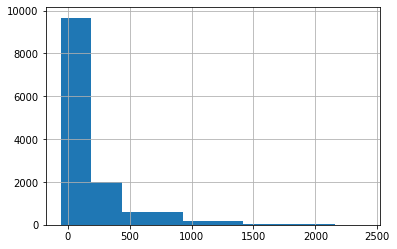

In [ ]:
df_schools['elevation_meters'].hist()

In [ ]:
df_schools['elevation_meters'].min()

-55.75

In [ ]:
df_schools['elevation_meters'].max()

2401.52

# Get Elevation at Pollution Point Sources

In [14]:
# only keeping the lat/lon fields so that we get the fewest count of distinct values
#df_ps = df_all[['year', 'cdscode', 'point_source_lat', 'point_source_lon']]
df_ps = df_all[['point_source_lat', 'point_source_lon']].drop_duplicates()
print(df_ps.shape)
df_ps.head(3)

(3330, 2)


,point_source_lat,point_source_lon
0,37.1056,-120.2487
8,35.15125,-118.01667
12,35.513841,-118.901299


In [ ]:
# run the function
df_ps['elevation_meters'] = df_ps.progress_apply(lambda df: get_elevation(df['point_source_lat'], df['point_source_lon']), axis=1)

# save results (just to csv b/c this one's smaller)
fpath = os.path.join(data_path, '../Point source/pollution_point_source_elevations.csv')
df_schools.to_csv(fpath)

  0%|          | 0/3330 [00:00<?, ?it/s]